## **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [2]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Most important package
import numpy as np

# The reinforcement learning environment
from gridworld import GridWorld

# Configure nice figures
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(14,7)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

---
## **1. Reinforcement Learning, introduction**
In the previous assignments we have explored supervised learning, in other words, methods that train a model based on known inputs and targets. This time, we will instead look at a branch of machine learning that is much closer to the intuitive notion of "learning". Reinforcement learning, or RL for short, does not work with inputs and targets, but instead learns by performing **actions** in an **environment** and observing the generated **rewards**.

RL is a very broad concept and many different algorithms have been deviced based on these general concepts of actions and rewards. Perhaps the main advantage of RL over other machine learning techniques is that we do not explicitly tell the model what the right answer is (like we have done in the previous assignments), but instead only tell the model when the desired outcome has been acheived. This might seem like the same thing at first, but the key difference is that RL allows the model to device solutions that outperform the human teacher. This is usually not possible in traditional supervised learning since the model can only get as good as the training data (the teacher). With the freedom to explore new strategies, which is inherent to RL, this is no longer true and some truly astounding results have been acheved. The most famous example is probably AlphaGo, the first computer program to beat a human expert in the board game Go. [Here is an excellent documentary](https://youtu.be/WXuK6gekU1Y), if you have some time to spare. For those of you that want a quicker and more fun example, [here is a video about RL agents playing hide and seek](https://youtu.be/kopoLzvh5jY), which very clearly demonstrates the power of RL to invent new and hidden strategies.

Of course, these examples are from the very forefront of current research in RL, and are unfortunately too complex for this assignment. We will instead work on a much simpler problem, but the core concepts that you will implement and investigate here are the same that made the above possible.

### **1.1 Getting to know the environment interface**
To do this assignment you must first get familiar with the code interface to the environment, or "World", as we will call it. You will work with a special type of environment called a **GridWorld**. The GridWorld is, as the name suggests, a world where each state is represented by a square on a grid. To create an instance of a GridWorld, run the following code. You can change the input number to select a different world. You will work with worlds 1-4, but there are other optional worlds as well, which we encourage you to explore at the end of the notebook.

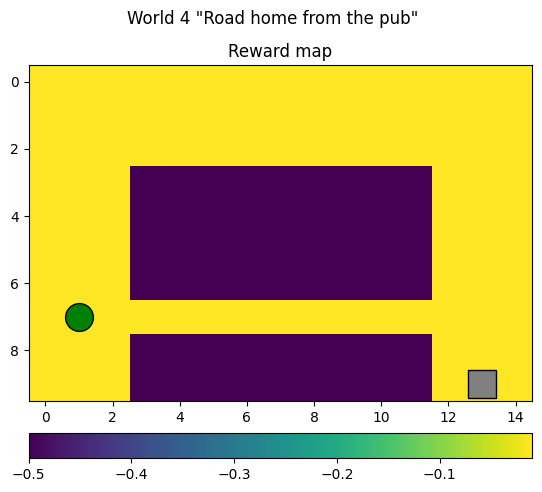

In [46]:
W = GridWorld(4)
W.init()
W.draw()

#### **<span style="color:red">Question 1:</span>**
The colored background represents the reward for entering each state. Notice that all rewards are negative. Can you think of why this is important?

#### **<span style="color:green">Answer:</span>**
The rewards are negative because we want the agent to take as few steps as possible

The **Agent** is represented by the gray square, and will traverse the environment in order to reach the **goal** state, represented by the green circle.
You can access all information you need regarding the state of the GridWorld by the methods of the World class. Here is the full list with explanations for each method:

* `getWorldSize()` - Returns a tuple with the size of each dimension in the state space. For the GridWorlds, this is the y-size and x-size of the grid.
* `getDimensionNames()` - Returns a list with the names for each dimension. This is only used to understand the world better, and should not be used to design the algorithm.
* `getActions()` - Returns a list of available actions in the form of strings. These are the only accepted values to pass to `doAction`.
* `init()` - Initializes the World. For example this resets the position of the agent in the GridWorlds. Do this at the beginning of each epoch.
* `getState()` - Returns the current state of the World, which for a GridWorld is the position of the agent.
* `doAction(act)` - Performs an action and returns a 2-tuple indicating if the actions was valid, and the corresponding reward.
* `draw(epoch, Q)` - Update any plots associated with the World. The two arguments are optional but will include more information in the plots if you provide them.

Here are some examples:

In [4]:
W = GridWorld(1)
print("World size:", W.getWorldSize())
print("Dimension names:", W.getDimensionNames())
print("Actions:", W.getActions())

World size: (10, 15)
Dimension names: ['Y', 'X']
Actions: ['Down', 'Up', 'Right', 'Left']


Here is an example of some actions in the first GridWorld. Read the code and output and make sure you understand how this works before proceeding. You can quickly run the cell multiple times by holding `Ctrl` and pressing `Enter` to generate a new output.

In [5]:
W = GridWorld(1)
W.init()

# Check state
state, isTerm = W.getState()
print(f"State initialized to {state}.")

# Make action
a = "Down"
isValid, reward = W.doAction(a)
print(f"Action '{a}' was {'' if isValid else 'not '}valid and gave a reward of {reward}.")

# Check state
state, isTerm = W.getState()
print(f"State is {state} and is {('' if isTerm else 'not ')}terminal.")

# Make action
a = "Right"
isValid, reward = W.doAction(a)
print(f"Action '{a}' was {'' if isValid else 'not '}valid and gave a reward of {reward}.")

# Check state
state, isTerm = W.getState()
print(f"State is {state} and is {('' if isTerm else 'not ')}terminal.")

State initialized to (7, 2).
Action 'Down' was valid and gave a reward of -0.1.
State is (8, 2) and is not terminal.
Action 'Right' was valid and gave a reward of -0.1.
State is (8, 3) and is not terminal.


---
## **2. Implementing the Q-learning algorithm**
You will now implement the main algorithm of this assignment, **Q-learning**. This algorithm is powerful since it allows the simultaneous exploration of different **policies**. This is done by a state-action table **Q**, keeping track of the expected reward associated with each action in each state. By iteratively updating these estimates as we get new rewards, the policies explored by the agent eventually converges to the optimal policy. This can all be summarized in the following equation:

$$ \large Q\left(s_t,a\right) \leftarrow \underbrace{Q\left(s_t,a\right)}_{\mathrm{Old \space value}} \cdot \left(1-\alpha\right) + \alpha \cdot \underbrace{\left(r + \gamma V\left(s_{t+1}\right)\right)}_{\mathrm{New \space estimate}} $$

This defines that the value of $Q$ in a state $s_t$ for action $a$, i.e $Q\left(s_t,a\right)$, should be updated as a weighted average of the old value and a new estimate, where the weighting is based on the learning rate $\alpha \in (0,1)$. The new estimate is a combination of the reward $r$ for the action we are updating, and the estimated value $V$ of the next state $s_{t+1}$, discounted by the factor $\gamma \in (0,1]$. By increasing $\gamma$, the future value is weighted higher, which is why we say that this optimizes for long-term rewards.

### **2.1 The training function**
First, you will implement the Q-learning algorithm training loop in the following function. The inputs to this function is a World object, and a dictionary for any parameters needed for the training. This dictionary will contain the following parameters, which you will need `params = {"Epochs": 100, "MaxSteps": 100: "Alpha": 0.5: "Gamma": 0.9, "ExpRate": 0.5, "DrawInterval": 100}`. Note that these values are only examples, you will have to change them when optimizing each world. You access the content of the dictionary by it's name, for example `params["Gamma"]`. Using this style makes it very easy later in the notebook to try new worlds and parameter combinations.

Finally before you begin, here are some concrete tips to keep in mind while working:
* Try your code often! Jump ahead to section 3.1 to easily run the training in the first GridWorld.
* As part of this implementation, you must also implement the functions `getpolicy` and `getvalue` in `utils.py`. When you have implemented these the `draw` function will automatically show the results of the training!

In [104]:
def QLearning(World, params={}):
    
    # Init world and get size of dimensions
    WSize = World.getWorldSize()
    A = World.getActions()
    number_of_actions = len(A)

    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    LEARNING_RATE = params["LR"]
    DISCOUNT_FACTOR = params["Gamma"]
    EXPLORATION_RATE = params["Eps"]
    
    # Initialize the Q-matrix based on the world size
    world_width = WSize[0]
    world_height = WSize[1]
    Q = np.zeros((world_width, world_height, number_of_actions))
    
    for i in range(params["Epochs"]):
        World.init()

        # Limiting the number of steps in an epoch prevents getting stuck in infinite loops
        for j in range(params["MaxSteps"]):
            state, isTerminated = World.getState()

            if np.random.rand() < EXPLORATION_RATE:
                action = np.random.choice(A)
            else:
                action = A[np.argmax(Q[state[0], state[1]])]
            
            is_valid, reward = World.doAction(action)
            newState, is_terminated = World.getState()
            
            V = np.max(Q[newState[0], newState[1]])
            if not is_valid:
                reward = -0.1
            Q[state[0], state[1], A.index(action)] = Q[state[0], state[1], A.index(action)] * (1 - LEARNING_RATE) + LEARNING_RATE * (reward + DISCOUNT_FACTOR * V)
            
            if is_terminated:
                break
        
        # Update plots with regular intervals
        if ((i+1) % params["DrawInterval"] == 0) or (i == params["Epochs"]-1):
            World.draw(epoch=(i+1), Q=Q)
    
    # ============================================
        
    return Q

### **2.2 The test function**
It's important to test the performance of the trained model. This *could* be done with some heuristic function that measures properties such as path lenghts and total rewards, but here we choose to instead use a more direct evaluation method. In the following function you should implement a test loop where you follow the optimal policy and draw the world after *each* action. Since this is code to test the trained model, you should not update Q, only use it to determine the optimal actions.

In [105]:
def QLearningTest(W, Q, params={}):
    
    # The number of epochs is now the number of tests runs to do
    for i in range(params["Epochs"]):
        
        # Init the world and get state
        W.init()
        A = W.getActions()
        s,_ = W.getState()

        # Again we limit the number of steps to prevent infinite loops
        for j in range(params["MaxSteps"]):
            
            # --------------------------------------------
            # === Your code here =========================
            # --------------------------------------------
            
            # Choose and perform optimal action from policy
            action_index = np.argmax(Q[s[0], s[1]])
            action = A[action_index]

            # Perform action and get new state and reward
            is_valid, reward = W.doAction(action)

            # ============================================
            
            # Get updated state and draw
            s,isTerm = W.getState()
            W.draw(epoch=(i+1), Q=Q)
            
            # Check if goal
            if isTerm:
                break

---
## **3. Optimizing the different worlds**

In this section you will optimize the hyperparameters to train the 4 first GridWorlds. 

### **3.1 GridWorld 1**
We start with the simplest of the worlds, "Annoying block". The policy should converge without much difficulty, so use this as a test to see if your implementaion is correct. If you use a good set of hyperparameters, you can expect a rather neat policy in about 1000 epochs.

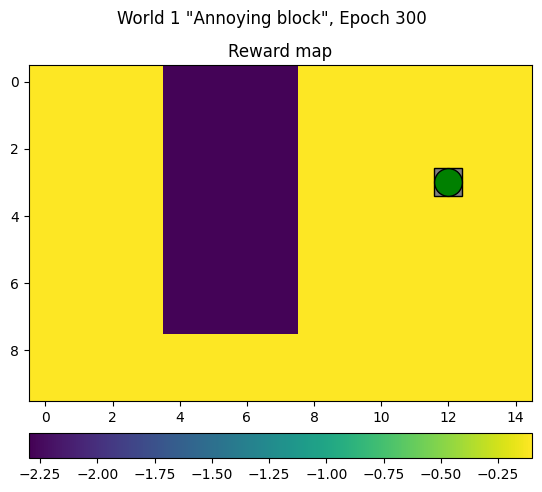

In [33]:
W1 = GridWorld(1)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q1 = QLearning(W1, params={"LR": 0.65, "Gamma": 0.75, "Eps": 0.5, "Epochs": 300, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

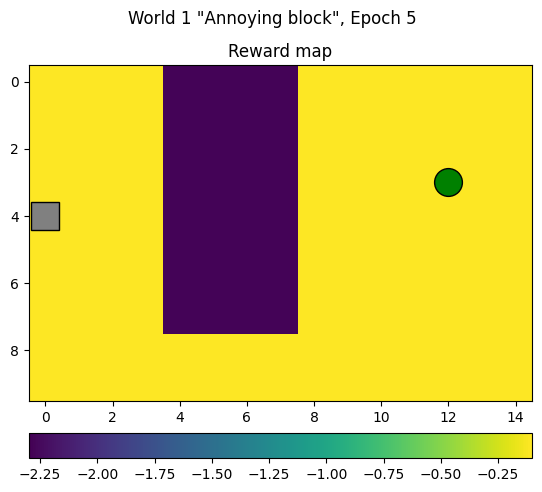

In [34]:
QLearningTest(W=W1, Q=Q1, params={"Epochs": 5, "MaxSteps": 32})

#### **<span style="color:red">Question 2:</span>**
1. Describe World 1.
2. What is the goal for the agent in this world?
3. What is a good choice of learning rate in this world? Motvate your answer.

#### **<span style="color:green">Answer:</span>**
1.
A large yellow area for the agent to traverse and a purple area in the middle which the agent is encouraged to avoid.

2.
The goal of the agent is to reach the green dot on the map (the goal, as it were) in as few steps as possible.

3.
Too high (0.8) or too low (0.2) seem to make the agent worse. Closer to the middle was better.

Now continue optimizing worlds 2-4. Note that the optimal hyperparmeters potentially are very different for each world.

### **3.2 GridWorld 2**

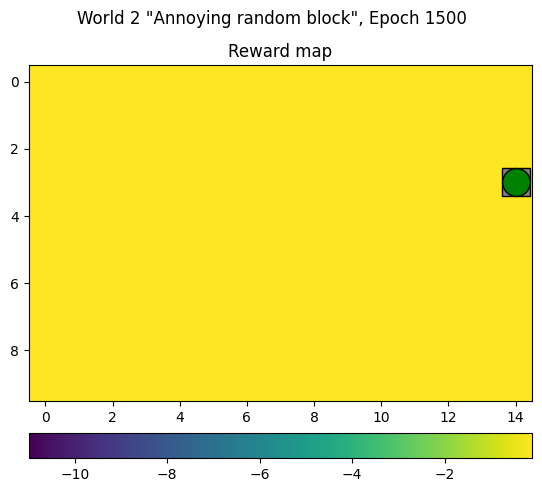

In [10]:
W2 = GridWorld(2)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
Q2 = QLearning(W2, params={"LR": 0.35, "Gamma": 0.75, "Eps": 0.5, "Epochs": 1500, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

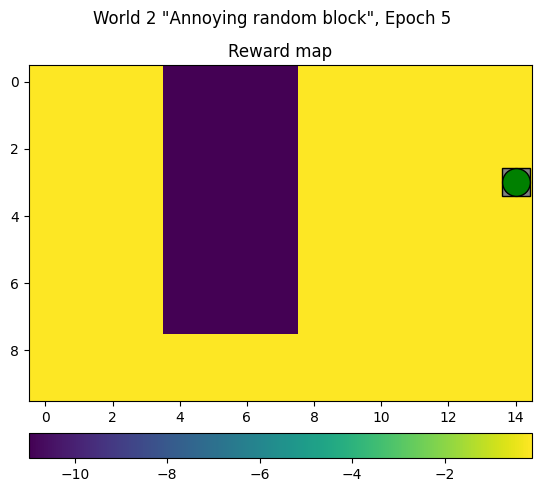

In [11]:
QLearningTest(W=W2, Q=Q2, params={"Epochs": 5, "MaxSteps": 32})

#### **<span style="color:red">Question 3:</span>**
1. Describe World 2.
2. This world has a hidden trick. Describe this trick and why this can be solved with reinforcement learning.
3. What is the goal for the agent in this world?
4. What is a good choice of learning rate in this world? Motvate your answer.
5. Compared to the optimal policy in World 1, how do we expect the optimal policy to look in this world? Motivate your answer.

#### **<span style="color:green">Answer:</span>**

1. World 2 is similar to wold 1 in that it sometimes as a block with low reward. The differnece is that the reward is much lower and that the block isn't always there.
2. The hidden trick is that the world is changeing during the trainig, and can be solved with reinforcement learning because we don't need to know the solution beforehand.
3. The goal is to reach the green dot with as high reward as possible. Since the agent won't know if there are any blocks with super low reward, it should always take the safe route around.
4. The learning rate for this world should be lower than world 1, so that it doesn't overtrain for any specific world layout.
5. Basically the same beacause we don't ever want to cross the purple block, which may or may not be there. 

### **3.3 GridWorld 3**

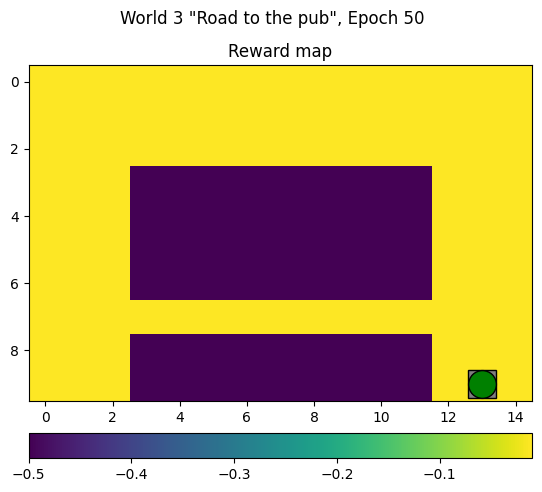

In [114]:
W3 = GridWorld(3)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q3 = QLearning(W3, params={"LR": 0.95, "Gamma": 0.9, "Eps": 0.5, "Epochs": 50, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable.

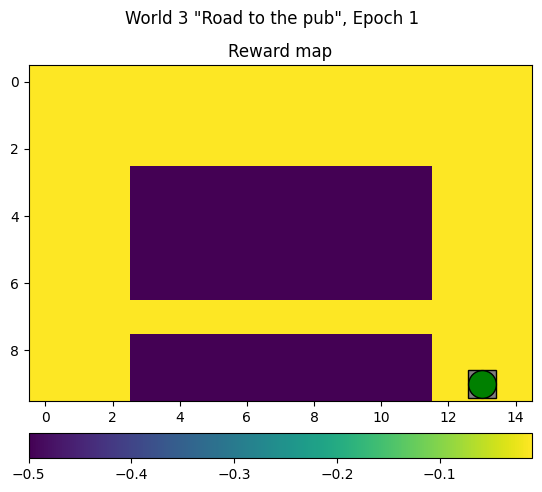

In [111]:
QLearningTest(W=W3, Q=Q3, params={"Epochs": 1, "MaxSteps": 15})

#### **<span style="color:red">Question 4:</span>**
1. Describe World 3.
2. From the perspective of the learning algorithm, how does this world compare to World 1?
3. What is the goal for the agent in this world?
4. Is it possible to get a good policy in every state in this world? If so, which hyperparameter is particulary important to acheive this?

#### **<span style="color:green">Answer:</span>**

1.
World 3 is similar to world 1 but with two obstacles instead of one. Another difference is that the agent starts in the same position every time.

2.
The only difference for the learning algorithm is that the agent always starts in the same position, which means that the algorithm can use a much higher learning rate. This also means that it isn't completely necessary to explore the entire world. For example, the algorithm doesn't need to learn how it should behave when the agent is in the purple area.

3.
The goal for the agent is to reach the green dot with as high reward as possible, which means walking through the "corridor" between the two obstacles.

4.
To force the agent into exploring more of the world to learn a good policy in every state, a high exploration rate can be used.

### **3.4 GridWorld 4**

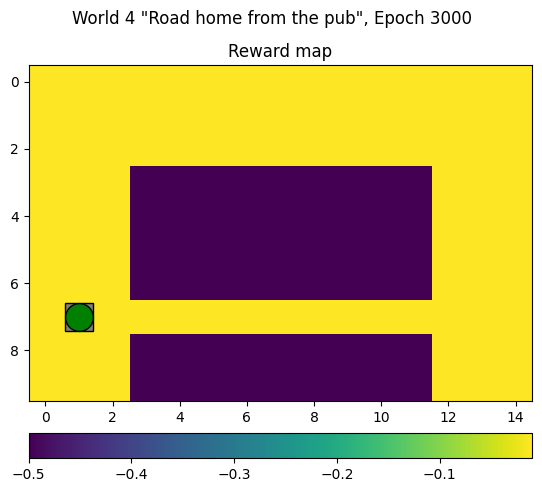

In [122]:
W4 = GridWorld(4)

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q4 = QLearning(W4, params={"LR": 0.2, "Gamma": 0.95, "Eps": 0.5, "Epochs": 3000, "MaxSteps": 300, "DrawInterval": 100})

# ============================================

Don't forget to run a few tests with the optimized policy to see if the solution looks reasonable. **Important**: You might think the policy above looks bad, but we encourage you to run this test even if you think it's not optimal. It might give you some insight into the world behaviour.

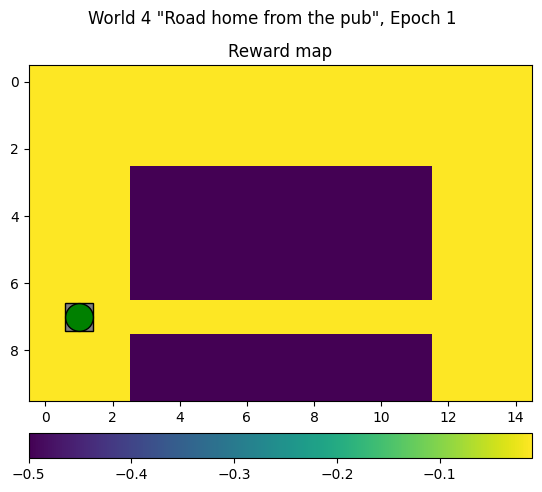

In [124]:
QLearningTest(W=W4, Q=Q4, params={"Epochs": 1, "MaxSteps": 100})

#### **<span style="color:red">Question 5:</span>**
1. Describe World 4 using your own words. 
2. This world has a hidden trick. What is it, and how does this world differ from World 3?
3. What is the goal for the agent in this world?
4. What is a good choice of learning rate in this world? Motvate your answer.
5. How should we expect the optimal policy too look like? In other words, what is the optimal path from start to goal in this world? Motivate your answer.

#### **<span style="color:green">Answer:</span>**

1.
World 4 is similar to world 3, but that start and goal position is swapped.

2.
The hidden trick is that the world will perform the wrong action in 30% of the cases.

3.
The goal for the agent is to find the optimal path to the goal. In this case, it would be to walk the long way around, since it is safer in case of miss steps.

4
The learning rate should be much lower, since the actions of the agent isn't reliable, so the algorithm should be more careful when updating the Q-table.

5.
The optimal path would be to walk the long way around, since it is safer in case of miss steps. If the agent tried to walk the short path, it would most likely accidentally step in to the purple area and get a lower reward than it would if it tried to walk around it.

---
## **4. Investigating the effects of hyperparameters**
You will now design a series of experiments to show the impact of the three main hyperparameters - learning rate, discount factor, and exploration rate - in different environments. You are free to extend the experiments as you see fit in order to make your point in the discussions, but a recommended strategy is to try two extreme cases (low vs high values). For each parameter, there is one world in particular of the four you have already used where it is easy to show the effects we are looking for. Figuring out which worlds is part of the excercise.

### **4.1 Learning rate**

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

W_LR = GridWorld(???)
Q_41_L = QLearning(W_LR, params={"LR": ???, "Gamma": ???, "Eps": ???, "Epochs": ???, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q_LR_H = QLearning(W_LR, params={"LR": ???, "Gamma": ???, "Eps": ???, "Epochs": ???, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 6:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

#### **<span style="color:green">Answer:</span>**
\[ Your answer here \]

### **4.2 Discount factor (gamma)**

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

W_DF = GridWorld(???)
Q_DF_L = QLearning(W_DF, params={"LR": ???, "Gamma": ???, "Eps": ???, "Epochs": ???, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q_DF_H = QLearning(W_DF, params={"LR": ???, "Gamma": ???, "Eps": ???, "Epochs": ???, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 7:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

#### **<span style="color:green">Answer:</span>**
\[ Your answer here \]

### **4.3 Exploration rate (epsilon)**

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

W_ER = GridWorld(???)
Q_ER_L = QLearning(W_ER, params={"LR": ???, "Gamma": ???, "Eps": ???, "Epochs": ???, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

Q_ER_H = QLearning(W_ER, params={"LR": ???, "Gamma": ???, "Eps": ???, "Epochs": ???, "MaxSteps": 200, "DrawInterval": 100})

# ============================================

#### **<span style="color:red">Question 8:</span>**
Explain your experiment and results, and why you choose this world (your answers should be based on the output of the cells above).

#### **<span style="color:green">Answer:</span>**
\[ Your answer here \]

---
## **5. Optional worlds**

You have now investigated the four most important GridWorlds in the lab, but we have also created some optional worlds (numbers 5 to 7) which you can try to solve. There is also World 8, but that is a special case, so scroll down a few cells if you are interested. Here is a brief description of World 5 to 7:
- World 5, Warpspace: As the name suggests, in this world there is one tile in which the agent enters warpspace and imediatly moves to another specific location. How do you think this will affect the learning?
- World 6, Torus: In this world, the opposite edges are connected together like a rolled-up paper. If you connect both the up-down and left-right edges, you get a mathematical shape called a torus which has no edges. This means that the closest path to the goal might not be obvious anymore.
- World 7, Steps: This world is a staircase of increasing rewards (although still all negative). However, moving up the stairs towards higher rewards also puts the agent further from the goal. So what is the optimal choice, to go for the long path with higher rewards, or to sprint throught the low rewards towards the goal. This depends on the value of gamma.

In [ ]:
WOpt = GridWorld( ??? )
QOpt = QLearning(WOpt, {"LR": 0.99, "Gamma": 0.9, "Eps": 0.9, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

In [ ]:
QLearningTest(W=WOpt, Q=QOpt, params={"Epochs": 5, "MaxSteps": 100})

### **5.1: World 8**

So far, every world has been a 2D-grid (y and x dimensions), and the four actions have been the same in every world. It has therefore been possible to write the code with this in mind, probably resulting in code where you index Q for example with `Q[s[0], s[1], a]` for a given state `s` and action `a`. However, it is possible to slightly rewrite the code to be independent of the number of dimensions in the state space, which means that we can then explore much more interesting worlds. It is also a nice excercise in how to write code that is general and modular. The way to do this is to index Q in the following way: `Q[(*s,a)]`. It's perfectly fine if you want to consider this as "python magic", but for the interested here is an explaination.

The state `s` is a tuple, for example `(3,6)`. A quirk in python is that tuples can be used to index into arrays, with each value in the tuple indexing separate dimensions in the array. For example, if Q is a 10x15x4 array, then `Q[(3,6)]` will return the vector of four values in Q that are in the 3rd row and 6th column (i.e. all the action values for state `s = (3,6)`). The problem is that we want to access the Q-value of a specific action when updating with a new reward. One might assume that `Q[s,a]` would work, but this now works differently since we explicitly index Q with not only a tuple. The solution is to remake a tuple that contains both `s` and `a`, and then index Q with this. We can do this by first unpacking the state tuple by calling `*s`, then creating a new tuple with `(*s,a)`, containing both the state and action. For example, if `s = (3,6)` and `a = 2`, then `(*s,a) = (3,6,2)`. We then use this tuple to index into Q as `Q[(*s,a)]`.

With this change to the implementation, we can for example extend the world to a 3D-grid, and your code should work the same. Let's try it in World 8, where the agent has the choice of moving between two floors of the map. This is shown as diagonal up or diagonal down arrows.

In [ ]:
W8 = GridWorld(8)
Q8 = QLearning(W8, {"LR": 0.99, "Gamma": 0.9, "Eps": 0.9, "Epochs": 1000, "MaxSteps": 200, "DrawInterval": 100})

In [ ]:
QLearningTest(W=W8, Q=Q8, params={"Epochs": 5, "MaxSteps": 100})